In [7]:
from os import listdir
from os.path import join
import numpy as np
from tslearn.metrics import dtw, dtw_path
import sys
import ot
sys.path.append('../src/OPW')
from opw import opw_sinkhorn
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../src/GOW')

In [8]:
def warping_path_to_warping_matrix(warping_path, len_seq1, len_seq2):
    warping_matrix = np.zeros((len_seq1, len_seq2))
    
    for (i, j) in warping_path:
        warping_matrix[i][j] = 1

    return warping_matrix
    

def full_fname2_str(data_dir, fname, sep_char):
    fnametostr = ''.join(fname).replace(data_dir, '')
    ind = int(fnametostr.index(sep_char))
    label = int(fnametostr[ind + 1:ind + 3])
    return label

def frame_normalizer(frame, frame_size):
    assert frame.shape[0] == frame_size
    frame = frame.reshape(frame_size // 3, 3)
    spine_mid = frame[1]
    new_frame = []
    j = 0
    for joint in frame:
        new_frame.append(joint - spine_mid)
        j += 1
    new_frame = np.asarray(new_frame)
    return (list(new_frame.flatten()))


def read(data_dir):
    print('Loading MSR 3D Data, data directory %s' % data_dir)
    data, labels, lens, subjects = [], [], [], []
    filenames = []
    documents = [join(data_dir, d)
                 for d in sorted(listdir(data_dir))]
    filenames.extend(documents)
    filenames = np.array(filenames)

    for file in filenames:
        action = np.loadtxt(file)[:, :3].flatten()
        labels.append(full_fname2_str(data_dir, file, 'a'))
        frame_size = len(action) // 60  # 20 iskeleton num x,y,z 3D points
        lens.append(frame_size)
        action = np.asarray(action).reshape(frame_size, 60)
        
        new_act = []
        for frame in action:
            new_act.append(frame)

        data.append(new_act)
        subjects.append(full_fname2_str(data_dir, file, 's'))
        
    data = np.asarray(data, dtype=object)
    labels = np.asarray(labels) -1
    lens = np.asarray(lens)
    
    subjects = np.asarray(subjects)
    print("All files read!")
    print('initial shapes [data label len]: %s %s %s' % (data.shape, labels.shape, lens.shape))
    return data,labels,lens, filenames

In [9]:
MSR_data_dir = '../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/'
# sitting and standing up
data,labels,lens,filenames = read(MSR_data_dir)

Loading MSR 3D Data, data directory ../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/
All files read!
initial shapes [data label len]: (567,) (567,) (567,)


In [10]:
A, B = np.partition(lens, 1)[0:2]

In [11]:
print(A, B)

13 15


In [12]:
np.where(lens == 13)

(array([484], dtype=int64),)

In [13]:
np.where(lens == 15)

(array([290], dtype=int64),)

In [14]:
print(filenames[290], '\n', filenames[484])
print(filenames[441], '\n', filenames[444])

../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/a11_s05_e02_skeleton3D.txt 
 ../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/a18_s03_e02_skeleton3D.txt
../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/a16_s09_e01_skeleton3D.txt 
 ../Datasets/MSRAction3D/MSRAction3DSkeletonReal3D/a16_s10_e01_skeleton3D.txt


In [15]:
seq1 = np.array(data[290])
seq2 = np.array(data[484])

# DTW

<Axes: >

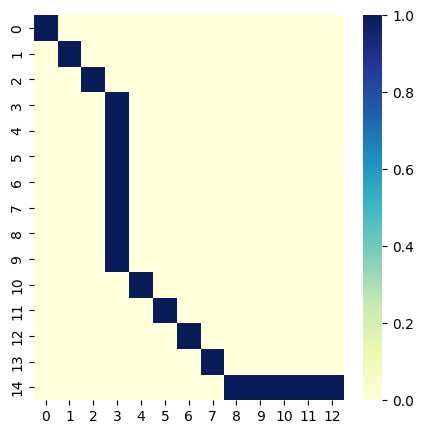

In [16]:
warping_path, similarity_score = dtw_path(seq1, seq2)
warping_matrix = warping_path_to_warping_matrix(warping_path, len(seq1), len(seq2))

plt.figure(figsize=(5,5))
sns.heatmap(warping_matrix, cmap="YlGnBu", annot=None)

In [17]:
warping_path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 3),
 (5, 3),
 (6, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (10, 4),
 (11, 5),
 (12, 6),
 (13, 7),
 (14, 8),
 (14, 9),
 (14, 10),
 (14, 11),
 (14, 12)]

# OPW

<Axes: >

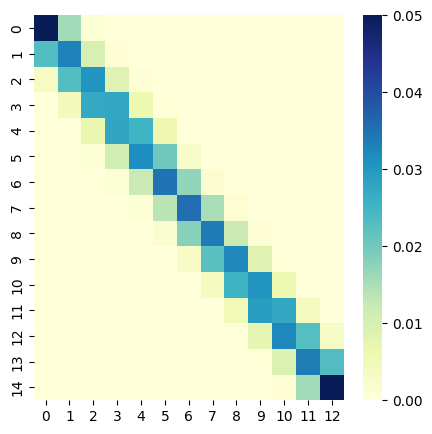

In [18]:
C = ot.dist(seq1, seq2, metric='minkowski')
a = np.ones(len(seq1)) / len(seq1)
b = np.ones(len(seq2)) / len(seq2)
LAMBDA1 = 20
LAMBDA2 = 0.2
P = opw_sinkhorn(a, b, C, lambda1=LAMBDA1, lambda2=LAMBDA2)
plt.figure(figsize=(5,5))
sns.heatmap(P, cmap="YlGnBu", annot=None)

<Axes: >

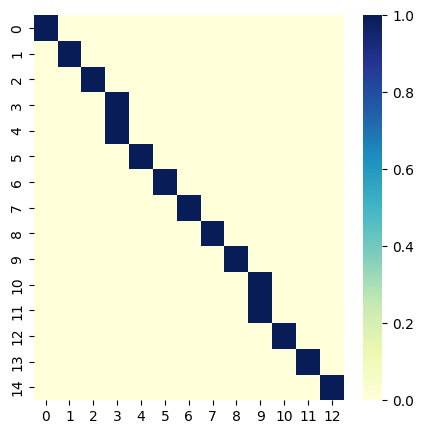

In [19]:
warping_path = []

for i in range(len(seq1)):
    warping_path.append((i, np.argmax(P[i])))

warping_matrix = warping_path_to_warping_matrix(warping_path, len(seq1), len(seq2))

plt.figure(figsize=(5,5))
sns.heatmap(warping_matrix, cmap="YlGnBu", annot=None)

In [20]:
warping_path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 9),
 (11, 9),
 (12, 10),
 (13, 11),
 (14, 12)]

# GOW

G:\CNTT\Python310\lib\site-packages\ot\bregman.py:517: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn("Sinkhorn did not converge. You might want to "


Iterations: 3


<Axes: >

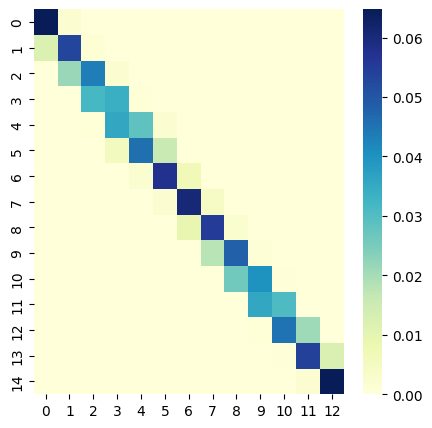

In [21]:
LAMBDA1 = 15
LAMBDA2 = 30

C = ot.dist(seq1, seq2, metric='minkowski')
a = np.ones(len(seq1)) / len(seq1)
b = np.ones(len(seq2)) / len(seq2)

C_new, P, w = GOW_sinkhorn_autoscale(a, b, C, LAMBDA1=LAMBDA1, LAMBDA2=LAMBDA2, maxIter=20, num_FW_iteration=1000, epsilon=0.0001)

plt.figure(figsize=(5,5))
sns.heatmap(P, cmap="YlGnBu", annot=None)

<Axes: >

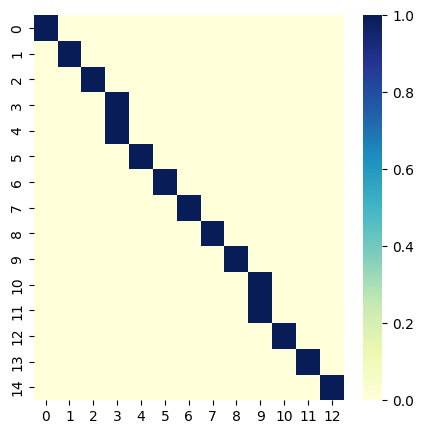

In [22]:
warping_path = []

for i in range(len(seq1)):
    warping_path.append((i, np.argmax(P[i])))

warping_matrix = warping_path_to_warping_matrix(warping_path, len(seq1), len(seq2))

plt.figure(figsize=(5,5))
sns.heatmap(warping_matrix, cmap="YlGnBu", annot=None)

In [23]:
warping_path

[(0, 0),
 (1, 1),
 (2, 2),
 (3, 3),
 (4, 3),
 (5, 4),
 (6, 5),
 (7, 6),
 (8, 7),
 (9, 8),
 (10, 9),
 (11, 9),
 (12, 10),
 (13, 11),
 (14, 12)]

In [24]:
w

array([[0.00555245],
       [0.0058961 ],
       [0.97779421],
       [0.00451349],
       [0.00624376]])